# Graph Agents
* The specific short project aims to combine the concepts of **multiagent systems** and **knowledge graphs**.
* A multiagent system consists of multiple artificial intelligence agents working collectively to perform tasks on behalf of a user or another system ([IBM](https://www.ibm.com/think/topics/multiagent-system)).
* A knowledge graph is an organized representation of real-world entities and their relationships. It is typically stored in a graph database, which natively stores the relationships between data entities ([Neo4j](https://neo4j.com/blog/what-is-knowledge-graph/)).
* The idea behind combining multiagent systems with knowledge graphs is to **enhance query answering** by leveraging the **agents' specialized reasoning capabilities** and the **knowledge graph's structured semantic relationships**, enabling more accurate, context-aware, and scalable solutions.
* The specific implementation consists of 3 steps:
    1. *Creation of the knowledge graph*: this is done with [GraphRAG](https://github.com/microsoft/graphrag).
    2. *Saving the graph in a database*: a [Neo4j](https://neo4j.com/) graph database is used.
    3. *Building the multiagent system for question answering*: using [AG2](https://github.com/ag2ai/ag2) (formerly AutoGen).

## Acknowledgements
* Three resources influenced the implementation:
    1. [GraphRag: Getting Started](https://microsoft.github.io/graphrag/get_started/)
    2. [Commit `cb0aae7` in GraphRAG](https://github.com/microsoft/graphrag/commit/cb0aae7e6bf1763ca5a7540d2220c11162863915)
    3. [Knowledge Graphs for RAG course by DeepLearning.AI](https://learn.deeplearning.ai/courses/knowledge-graphs-rag)

## 1. Creation of the knowledge graph
* GraphRAG calls this process [indexing](https://microsoft.github.io/graphrag/index/overview/).
* It is designed to:
    1. extract entities, relationships and claims from raw text
    2. perform community detection in entities
    3. generate community summaries and reports at multiple levels of granularity
    4. embed entities into a graph vector space
    5. embed text chunks into a textual vector space
* The process can be executed from the command line following the guidelines described in the [Getting Started](https://microsoft.github.io/graphrag/get_started/) page.


### Create the folder
* In this folder the indexing files will be saved.

In [1]:
import os

os.makedirs('./graph_agents_indexing/input', exist_ok=True)

### Download test data
* Download *Alice's Adventures in Wonderland* by Lewis Carrol (a personal favorite) from the [Gutenberg Project](https://www.gutenberg.org/).

In [2]:
!curl https://www.gutenberg.org/files/11/11-0.txt -o ./graph_agents_indexing/input/alice_in_wonderland.txt   

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  150k  100  150k    0     0   104k      0  0:00:01  0:00:01 --:--:--  107k


### Initialize GraphRAG
* Setup GraphRAG.
* To do so follow the guidelines in the section [Set Up your Workspace Variables](https://microsoft.github.io/graphrag/get_started/#:~:text=Set%20Up%20Your%20Workspace%20Variables) of the *Getting Started* page.
* *Important*: Additionally set the `embeddings` value under `snapshots` to true, to get the embeddings of the entities.

In [3]:
!graphrag init --root ./graph_agents_indexing > NUL 2>&1

### Index data
* Run the indexing process

In [4]:
!graphrag index --root ./graph_agents_indexing > NUL 2>&1

* Now the results of the process are saved in parquet files within the `./graph_agents_indexing/output` folder.

## 2. Saving the graph in a database
* A powerful database option for graphs is [Neo4j](https://neo4j.com/).
* It uses nodes, relationships, and properties to represent and store data, enabling highly efficient querying and analysis of complex, interconnected information.
* The commit [`cb0aae7`](https://github.com/microsoft/graphrag/commit/cb0aae7e6bf1763ca5a7540d2220c11162863915) in GraphRAG was used as base for the `neo4j_loading.py` script.

### Neo4j installation (from [here](https://github.com/microsoft/graphrag/blob/1a13e0fd93cecca8b10eaa59860e5000d691d417/examples_notebooks/community_contrib/neo4j/graphrag_import_neo4j_cypher.ipynb#L19))
* You can create a free instance of Neo4j online. You get a credentials file that you can use for the connection credentials. You can also get an instance in any of the cloud marketplaces.
* If you want to install Neo4j locally either use Neo4j Desktop or the official Docker image: `docker run -e NEO4J_AUTH=neo4j/password -p 7687:7687 -p 7474:7474 neo4j`
* *Important*: To execute the cell below fill `neo4j_config.json` with your Neo4j credentials.

In [3]:
import json
import neo4j_loading
from neo4j import GraphDatabase

# load the Neo4j configuration
with open("neo4j_config.json") as f:
    config = json.load(f)

# create a Neo4j driver
driver = GraphDatabase.driver(config["uri"], auth=(config["username"], config["password"]))

neo4j_loading.load(driver)

Data loaded successfully.


## 3. Building the multiagent system for question answering
* [AG2](https://github.com/ag2ai/ag2) (formerly AutoGen) is a popular framework for building multiagent systems.
* First, we will set it up.
* *Important:* Fill the `openai_config.json` with your OpenAI credentials, as it is described [here](https://ag2ai.github.io/ag2/docs/topics/llm_configuration/). Additionally, similarly to the GPT model, create an item in the list of the embedding model, that will be used later (must include *embedding*) in the `model` value).



In [1]:
import autogen
import re
from typing import Dict, Union, List, Optional, Tuple

config_list = autogen.config_list_from_json(
    "openai_config.json",
)

llm_config={
        "cache_seed": 41,
        "config_list": config_list,
        "temperature": 0.4,
    }

### System Architecture
* The simple system will have the following architecture:

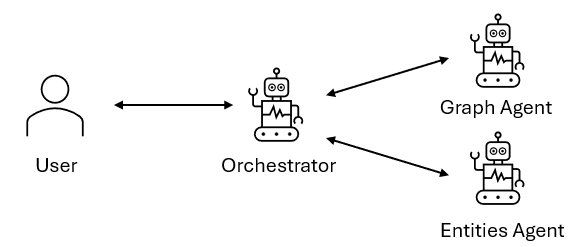

* The **Graph Agent** is responsible for querying the graph database to collect the necessary information.
* The **Entities Agent** identifies entities that are related to the given input.
* The **Orchestrator** interacts with the other two agents in order to collect the required information and return it to the user.

#### Graph Agent
* The Graph Agent takes the **database schema** and the **messages in the conversation** as input.
* It then **writes a [Cypher](https://neo4j.com/docs/getting-started/cypher/) query** and **executes** it.
* It returns the **output of the query** or the **exception raised**, alongside with the **suggested query**.
* To implement this logic, let's first extract the database schema.

In [4]:
def get_schema_formatted() -> str:
    """
    Get the schema of the graph in a clear format.
    """
    with driver.session() as session:
        # Get node labels and properties
        nodes_query = """
        MATCH (n)
        UNWIND labels(n) AS label
        RETURN label, collect(distinct keys(n)) AS properties
        """
        node_data = session.run(nodes_query).data()
        
        # Get example relationships (works for small graphs)
        example_relationships_query = """
        MATCH (a)-[r]->(b)
        RETURN DISTINCT labels(a) AS from, type(r) AS relationship, labels(b) AS to
        LIMIT 100
        """
        relationship_examples = session.run(example_relationships_query).data()
    
    # Format node properties
    node_properties = []
    for node in node_data:
        label = node['label']
        properties = node['properties']
        # Flatten property keys and add example types (hardcoded for demo)
        formatted_properties = ", ".join([f"{key}: STRING" for key in sorted(set(k for p in properties for k in p))])
        node_properties.append(f"{label} {{{formatted_properties}}}")
    
    # Format relationships
    relationships = []
    for example in relationship_examples:
        from_labels = ":".join(example["from"])
        to_labels = ":".join(example["to"])
        relationship = example["relationship"]
        relationships.append(f"(:{from_labels})-[:{relationship}]->(:{to_labels})")
    
    # Combine into final schema format
    schema = f"""
Node properties: 
{", ".join(node_properties)}

Relationships:
{', '.join(relationships)}
"""
    return schema


schema = get_schema_formatted()
print(schema)


Node properties: 
__Entity__ {description: STRING, embedding: STRING, human_readable_id: STRING, id: STRING, title: STRING}, Person {description: STRING, embedding: STRING, human_readable_id: STRING, id: STRING, title: STRING}, Organization {description: STRING, embedding: STRING, human_readable_id: STRING, id: STRING, title: STRING}, Geo {description: STRING, embedding: STRING, human_readable_id: STRING, id: STRING, title: STRING}, Event {description: STRING, embedding: STRING, human_readable_id: STRING, id: STRING, title: STRING}, __Community__ {community: STRING, full_content: STRING, level: STRING, rank: STRING, rank_explanation: STRING, summary: STRING, title: STRING}, Finding {explanation: STRING, id: STRING, summary: STRING}, __Document__ {id: STRING, title: STRING}, __Chunk__ {id: STRING, n_tokens: STRING, text: STRING}

Relationships:
(:__Community__)-[:HAS_FINDING]->(:Finding), (:__Chunk__)-[:PART_OF]->(:__Document__), (:__Chunk__)-[:HAS_ENTITY]->(:__Entity__:Person), (:__Ch

* The peculiarity of this agent is that it should not just write the Cypher script, but also **execute** it.
* To do this we will create a custom `GraphAgent` class, that extends `autogen.ConversableAgent`, and override its `generate_oai_reply` function.

In [ ]:
class GraphAgent(autogen.ConversableAgent):
    def __init__(self, name, system_message, llm_config, **kwargs):
        super().__init__(name=name, system_message=system_message, llm_config=llm_config, **kwargs)
    

    @staticmethod
    def _extract_cypher_block(text: str) -> str:
        """
        In case the cypher block is written inside ```cypher ... ```, extract the cypher query.

        Parameters:
            text (str): The text to extract the cypher query from.
        
        Returns:
            str: The extracted cypher query.
        """
        # regex pattern to match text within ```cypher ... ```
        pattern = r"```cypher(.*?)```"
        
        match = re.search(pattern, text, re.DOTALL)
        
        # if a match is found, return the matched text, else return the original text
        return match.group(1).strip() if match else text.strip()
    
    def generate_oai_reply(self,
                           messages: Optional[List[Dict]] = None,
                           sender: Optional[autogen.agentchat.agent.Agent] = None,
                           config: Optional[autogen.oai.client.OpenAIWrapper] = None,
                           ) -> Tuple[bool, Union[str, Dict, None]]:
        """
        Override the generate_oai_reply method to execute the cypher query and return the results.

        Parameters:
            messages (List[Dict]): The list of messages to generate a reply for.
            sender (autogen.agentchat.agent.Agent): The sender of the messages.
            config (autogen.oai.client.OpenAIWrapper): The OpenAI configuration.
        """
        success, response = super().generate_oai_reply(messages, sender, config)

        if not success:
            return success, response

        # the cypher query to execute
        query = self._extract_cypher_block(response)

        # the response to return
        graph_response = "Suggested query:\n" + query + "\n"
        try:
            query_output = driver.execute_query(query)

            records_returned = ""
            for r in query_output.records:
                # if embeddings are returned, remove them from the response as they are too large
                if type(r) is dict:
                    key = r.keys()[0]
                    data = r.data()[key]
                    record = {key: {k: v for k, v in data.items() if k != "embedding"}}
                    records_returned += json.dumps(record, indent=4) + "\n"
                
                else:
                    records_returned += str(r) + "\n"

            return success, graph_response + "\nRecords Returned:\n" + records_returned
        except Exception as e:
            exception = str(e)
            return success, graph_response + "\nException raised:\n" + exception

* Next, we will craft a specialized prompt, that incorporates the schema of the database.

In [6]:
graph_prompt = f"""
You are a Graph Agent that generates Cypher statements to query a graph database.
Use the provided schema to query the database successfully.
Schema:
{schema}
You have to produce ONLY the Cypher query, as your response will be taken as is to query the database.
*Note*: You don't have to answer the full query at once, you can collect information and then be asked again based on these.
**Important**: Be careful with the dashes in the names, the labels start and with double underscores (__), example: __Entity__. Also, the titles are written with full capital letters.
"""

* Now, we are ready to create a graph agent.

In [7]:
graph_agent = GraphAgent(
    name="Graph_Agent",
    system_message=graph_prompt,
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    )

#### Entities Agent
* The Entities Agent takes a query and identifies the **most related entities in the database** to the query.
* It does this using **embeddings**. Specifically, it maps the given query to a semantically reach vector, and compares it to the vector of the descriptions of each entity. It then returns the entities that are closer to the query (using cosine similarity).
* To implement this logic, we will create a `calculate_embedding` function.

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
from openai import AzureOpenAI, OpenAI

embedding_config = {}

# find the configuration for the embedding model
for model_config in config_list:
    if "embedding" in model_config["model"]:
        embedding_config = model_config
        break

if not embedding_config:
    raise ValueError("No embedding model found in the configuration.")

EMBEDDING_MODEL = embedding_config["model"]

# create the OpenAI client, either AzureOpenAI or OpenAI
if embedding_config.get("api_type", "openai") == "azure":
    OPENAI_CLIENT = AzureOpenAI(
        azure_endpoint=embedding_config["base_url"],
        api_key=embedding_config["api_key"],
        api_version=embedding_config["api_version"]
        )
else:
    OPENAI_CLIENT = OpenAI(
        api_key=embedding_config["api_key"],
        )


def calculate_embedding(text: str) -> List[float]:
    """
    Calculate the embedding for the given text.

    Parameters:
        text (str): The text to calculate the embedding for.
    Returns:
        List[float]: The calculated embedding.
    """
    return OPENAI_CLIENT.embeddings.create(input=text, model=EMBEDDING_MODEL).data[0].embedding

* Next, we will create a `get_related_entities` function.
* It will get a piece of text as input and will return the most related entities in the database.
* To do this, the `embedding` field of each entity will be used.
* Before implementing the function, and to avoid querying the database every time, all the entities will be extracted.

In [17]:
results = driver.execute_query("""
    MATCH (e:__Entity__)
    RETURN e.id AS id, e.title AS title, e.description AS description, e.embedding AS embedding
""")

ALL_ENTITIES = []
for record in results[0]:
    entity = {
        "id": record["id"],
        "title": record["title"],
        "description": record["description"],
        "embedding": record["embedding"]
    }
    ALL_ENTITIES.append(entity)

len(ALL_ENTITIES)

161

In [45]:
def get_related_entities(query, top_k=5):
    """
    Get the most related entities to a query from the Neo4j database.

    Args:
        query (str): The user query.
        top_k (int): Number of top related entities to return.

    Returns:
        List of dictionaries with entity information and similarity scores.
    """
    # calculate the embedding for the query
    query_embedding = calculate_embedding(query)

    # compute similarity scores
    similarities = {}
    for i, entity in enumerate(ALL_ENTITIES):
        similarities[i] = cosine_similarity([query_embedding], [entity["embedding"]])[0][0]

    # sort entities by similarity and return top_k
    related_entities_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:top_k]
    related_entities = [ALL_ENTITIES[i] for i in related_entities_indices]

    return related_entities

* Let's see an example.

In [46]:
related_entities = get_related_entities("Who is the closest to Alice?")
for entity in related_entities:
    print(entity["title"])

ALICE
SISTER
ALICE'S LOVE
DINAH
RABBIT


* This agent doesn't even have to call an LLM, it must take the last query and return the related entities.
* To do this we will again extend the `autogen.ConversableAgent`, and we will use the `register_reply` method, to make the agent reply using the `get_related_entities` function.

In [48]:
class EntitiesAgent(autogen.ConversableAgent):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)
        self.register_reply([autogen.Agent, None], EntitiesAgent.entities_reply)
    
    def entities_reply(self,
                       messages: Optional[List[Dict]] = None,
                       sender: Optional[autogen.agentchat.agent.Agent] = None,
                       config: Optional[autogen.oai.client.OpenAIWrapper] = None,
                       ) -> Tuple[bool, Union[str, Dict, None]]:
        query = messages[-1]["content"]
        similar_entities = get_related_entities(query, driver, top_k=5)
        response = ""
        for i, entity in enumerate(similar_entities):
            response += f"Entity {i+1}:\nTitle: {entity['title']}\nDescription: {entity['description']}\nSimilarity: {entity['similarity']}\n\n"
        return True, response
        

* We are now ready to initialize our Entities Agent.

In [49]:
entities_agent = EntitiesAgent(
    name="Entities_Agent",
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    )